# Insurance expenses prediction

The main goal of this notebook is to present a normal workflow of a regression problem. We will present first a exploratory data analyis (EDA), then we will use some out-of-the-box results, follow by the use of pipelines to improve the estimation, and at the end give the final conclussions. In this notebook is explore how to fit multiple ML models to try to predict the policy holder insurance charges. The data was generated by of [Brett Lantz](https://www.linkedin.com/in/brettlantz/) base on the U.S. Census Bureau database.

This type of analysis are useful for insurance companies since they help to narrow the policy holder's costs and increase revenue to the company. In general, an insurance company needs to collect more in yearly premiums than it spends on medical care to its beneficiaries. As a result, insurers invest a great deal of time and money to develop models that accurately forecast medical expenses.

The main goal of this analysis is to use patient information to estimate the medical care expenses that could happen in the duration of the contract. Moreover, the estimators could be used to create actuarial tables that are also mandatory under the Solvency II framework.

**The Docker image for this notebook could be dowloaded from** [here](https://github.com/kaggle/docker-python).

INTRODUCTION
1.Cover page followed by the title, names of authors, their affiliations, and contacts, name of the institutional publisher (if any), and the date of publication
2. Table of contents(ToC) contains a list of topics sub-topics, charts, graph and other pictorial information used in the report.
3. Abstract or summary of the report.
4. Introductory section which contains gently introduced to the subject matter and written in easily understandable formate.
BODY OF REPORT
5. Data Section: Include written descriptions of data and follow with relevant spreadsheets or variables in the data source.
6. Methodology Section — Contains research methods and data sources used in the report.
7. Analysis Section — Explain what we analyzed. Include any charts here.
8. Result Section followed by a discussion section. Describe the results of your analysis in the result section. The discussion section is where you rely on the power of narrative to enable numbers to communicate the thesis to your readers.
CONCLUSION
9. Conclusion Section: Concluding the overall report, outcomes of the report, application of the research in future.
10.References and acknowledgement section. Appendix is optional

<center> <img src="https://www.rushortho.com/sites/default/files/2016-10/AdobeStock_96790805.jpeg" alt="drawing" width="500"/> <center>

In [1]:
# General computation modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy as sp # to simulate uniform(0,1)
import time 
import os

# Data transformation modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Machine Learning modules
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor
# import xgboost as xgb
from xgboost.sklearn import XGBRegressor

## Exploratory Data Analysis

In order predict the charges of a policyholder, we have the following features to train our models:

* <b>age</b>: Age of primary beneficiary.
* <b>sex</b>: Insurance contractor gender, female, male.
* <b>bmi</b>: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9
* <b>children</b>: Number of children covered by health insurance / Number of dependents
* <b>smoker</b>: Smoking
* <b>region</b>: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* <b>charges</b>: Individual medical costs billed by health insurance

Let us see the first five rows of information.

In [3]:
df = pd.read_csv("input/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let us now take a look at the data types of each column; this will be important to define each feature transformation. Also, let us notice that the data does not has any missing value.

In [39]:
df.info() # Also we could use 'df.isnull().sum()'

Let us separate the data into train and test sets.

In [7]:
X = df.drop('charges', axis=1)
y = df.charges

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

By observing the data types of each column, we will use the next column transformer.

In [5]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

In [51]:

c_scores = cross_validate(pipe, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])
c_scores

## Methodology

Let us now continue with some out-of-the-box model to define a baseline of predictions. In particular, we will fit the
models `LinearRegression`, `Lasso` , `Ridge` `RandomForestRegressor`, and `XGBRegressor`

LinearRegression


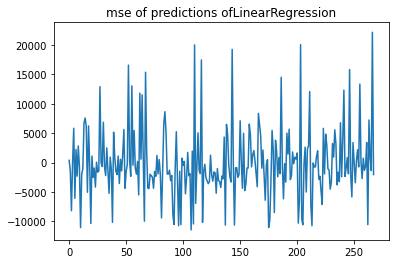

Lasso


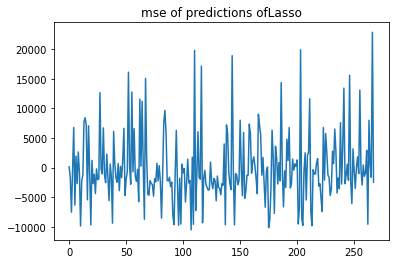

Ridge


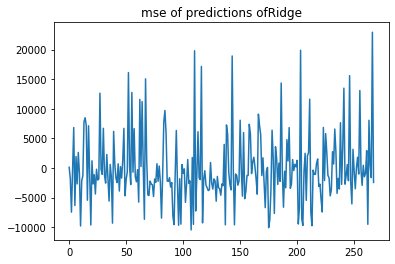

RandomForestRegressor


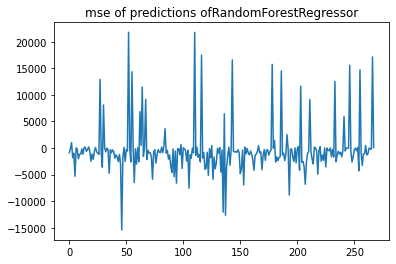

XGBRegressor


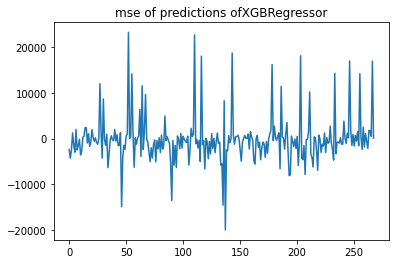

,model,rmse_mean,rmse_std,mae_mean,mae_std
0,LinearRegression,6149.258930,6.937061e+06,64.518835,403.478880
1,Lasso,6132.741975,6.538855e+06,65.083060,373.097415
2,Ridge,6133.084193,6.510691e+06,65.120572,372.159798
3,RandomForestRegressor,4927.236790,4.287591e+06,52.988192,176.809467
4,XGBRegressor,5391.772806,4.793278e+06,56.658149,228.313632


In [8]:
def model_results(model, results_df, model_name=None):
    """
    Given a model this function updats the dataframe results_df with the model's cross-validation (CV) results. This
    function also plots the errors with respect to the X_test and y_test sets.
    :param model: a machine learning model; eg. LinearRegression()
    :param results_df: a pd.DataFrame with the current CV information of the models
    :param model_name: an extra string with the name that will be use the information of the model. This variables
    is useful in case of having different instances of the model with different parameters. In case of None, it
    uses type(model).__name__
    :return: an update version of results_df with the `model`'s information
    """
    # Name of the model
    if model_name is None:
        model_name = type(model).__name__
    print(model_name)
    # Pipeline to do a cross validation
    pipe = make_pipeline(column_trans, model)
    # Results of the CV
    c_scores = cross_validate(pipe, X_train, y_train, cv=10,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'])
    # Extracting CV results
    mse_mean = np.sqrt(np.array(-c_scores['test_neg_mean_squared_error'])).mean()
    mse_std = c_scores['test_neg_mean_squared_error'].std()
    mae_mean =  np.sqrt(np.array(-c_scores['test_neg_mean_absolute_error'])).mean()
    mae_std = c_scores['test_neg_mean_absolute_error'].std()    
    fit_time_mean = c_scores['fit_time'].mean()
    # We define the new row of results_df
    new_row = [model_name, mse_mean, mse_std, mae_mean, mae_std]
    # Plot of predictions
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plt.plot(np.array(y_test)-y_pred)
    plt.title("mse of predictions of"+model_name)
    plt.show()
    # This if take cares of the case when resuls_df is empty
    if results_df.iloc[0,0]== 0:
        results_df.loc[0] = new_row
    else:
        results_df.loc[len(results_df.index)] = new_row
    return results_df

col_results = ['model', 'rmse_mean', 'rmse_std', 'mae_mean', 'mae_std']
models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), XGBRegressor()]
# models = [LinearRegression(), Lasso(), Ridge()]
results_df = pd.DataFrame(np.zeros([1,len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    results_df = model_results(model, results_df)


results_df


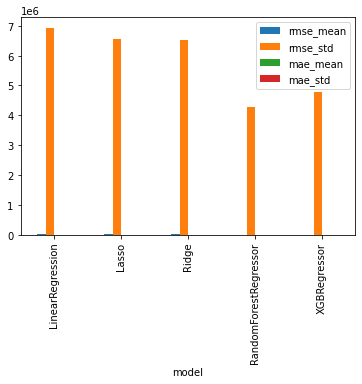

In [9]:
results_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
# plt.ylim([0,14])
plt.show()

Let us plot an scaled version of the `results_df` to compare graphically the models. For scaled version we mean that we
use `MinMaxScaler` to scale each of the numeric columns of `results_df`.

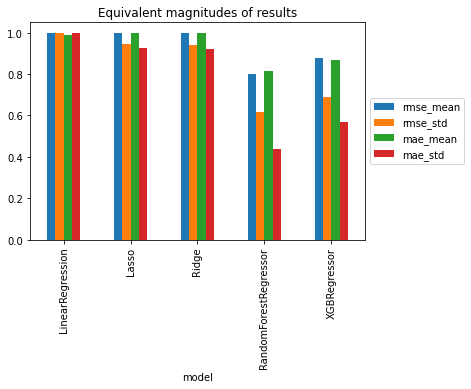

In [10]:
normalized_df = results_df.copy()
normalized_df.iloc[:,1:]=(results_df.iloc[:,1:].copy())/results_df.iloc[:,1:].max() 
normalized_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
# plt.ylim([0,2])
plt.title("Equivalent magnitudes of results")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can see that the best out-of-the-box models were the `RandomForestRegressor()` and `XGBRegressor()`. Accordingly, in
the next sections we will fine tune these two models using `GridSearchCV` to find the parameters and `Pipeline` to
control the workflow.

In [91]:

normalized_df = pd.DataFrame(MinMaxScaler().fit_transform(results_df.iloc[:,1:]))

normalized_df
# normalized_df['model'] = results_df.model.values
# normalized_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
# # plt.ylim([0,2])

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

In [95]:
normalized_df = results_df.copy()
aca = pd.DataFrame(MinMaxScaler().fit_transform(results_df.iloc[:,1:]))

normalized_df

aca
# normalized_df['model'] = results_df.model.values
# normalized_df.plot(x="model", y=['rmse_mean', 'rmse_std', 'mae_mean', 'mae_std'], kind="bar")
# # plt.ylim([0,2])

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

These out-of-the-box results tell us that a good candidates for continue our estimation are the Random Forest and the XGBoost algorithms. We could notice that the mean

In [ ]:
# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [ ]:
model = XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

parameters = {
    'num_boost_round': [10, 25, 50],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

pipe = make_pipeline(column_trans,StandardScaler(), model)
c_scores = cross_val_score(pipe, X, y, cv=5,scoring='neg_mean_squared_error')
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())

In [ ]:
model = linear_model.Lasso()
pipe = make_pipeline(column_trans,StandardScaler(),PolynomialFeatures(degree=4),StandardScaler(), model)
print(cross_val_score(pipe, X, y, cv=5).mean())

In [ ]:
# define the pipeline
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=3, include_bias=False)),
    ('estimator', Ridge(alpha=1))
])

# PIPELINE TUNING

How to tune a pipeline in this [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)

In [ ]:

# each of these models will take a turn as the second Pipeline step
model_1 = RandomForestRegressor()

ct = make_pipeline(column_trans,StandardScaler())

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

params1 = {}
params1['model__bootstrap'] = [True]
params1['model__max_depth'] = [80, 90, 100, 110]
params1['model'] = [model_1]

# create a list of parameter dictionaries
params = [params1]

grid = GridSearchCV(pipe, params, n_jobs=-1)
grid.fit(X, y)
grid.best_params_

In [101]:
# each of these models will take a turn as the second Pipeline step
model_1 = RandomForestRegressor()

model_2 = LinearRegression()

ct = make_pipeline(column_trans,StandardScaler())

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

params1 = {}
params1['model__bootstrap'] = [True, False]
params1['model__max_depth'] = [70, 80, 90, 100, 110]
params1['model__max_features'] = [2, 3, 4, 6, 10]
params1['model__min_samples_leaf'] = [2, 3, 4, 5, 6]
params1['model__min_samples_split'] = [5, 8, 10, 12]
params1['model__n_estimators'] = [100, 200, 300, 1000, 1500]
params1['model'] = [model_1]

params2 = {}
params2['model'] = [model_2]

# create a list of parameter dictionaries
# params = [params1, params2]

params = [params1]

grid = RandomizedSearchCV(pipe, params, n_jobs=-1, n_iter=20, verbose=1, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
model_name

In [102]:

model = grid.best_params_['model']

results_df = model_results(model, results_df, model_name = 'RandomForestRegressor_Tuned')
results_df


In [ ]:
# model__n_estimators': 100,
#  'model__min_samples_split': 8,
#  'model__min_samples_leaf': 4,
#  'model__max_features': 3,
#  'model__max_depth': 110,
#  'model__bootstrap': True,

model = grid.best_params_['model']
model

# model = RandomForestRegressor(**grid.best_params)

model_name = type(model).__name__
print(model_name)
pipe = make_pipeline(column_trans, model)
c_scores = cross_val_score(pipe, X_train, y_train, cv=4,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse_test_pred = np.sqrt(-c_scores.mean())
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-y_pred)
plt.show()

# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [ ]:
pipe.fit(X,y)

y_pred = pipe.predict(X)

In [ ]:
# model = xgb.XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )


In [ ]:


plt.plot(y-y_pred)

## Tuning XBGregression

In [106]:
import datetime
print(datetime.datetime.now())

# start = time.process_time()

# model = XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )

# Start
model_1 = XGBRegressor()
ct = make_pipeline(column_trans)
# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

my_n_estimators = 100

params1 = {}
# params1['model__gamma'] = [0]
params1['model__eta'] = [0.4, 0.3, 0.1, 0.01]
params1['model__max_depth'] = [1, 2, 3, 4]
params1['model__n_estimators'] = [my_n_estimators]
params1['model__subsample'] = sp.stats.uniform(scale=1)
params1['model__colsample_bytree'] = sp.stats.uniform(scale=1)

params1['model'] = [model_1]

# parameters = { #when use hyperthread, xgboost may become slower
#               'gamma': [0], #so called `eta` value
#               'max_depth': [3, 5, 6, 7],
#               'n_estimators': [50, 100, 200]}


grid = RandomizedSearchCV(pipe, params1, n_jobs=-1, n_iter=10, verbose=1, cv=3, random_state = 42)

# print(grid)
grid.fit(X_train, y_train)
grid.best_params_

end= time.process_time()
total = end-start
time= total/1000
print("my_n_estimators =", my_n_estimators," time ", time,"s")

# n_iter=10
# 10 -->  elapsed:   20.3s finished
# 20 -->  elapsed:   35.9s finished
# 40 -->  elapsed:  1.3min finished
# 80 -->  elapsed:  2.5min finished
# 200 -->  elapsed:  6.3min finished
# 1000 -->  elapsed:  30.8min finished

In [ ]:
grid.best_params_

In [ ]:
model = grid.best_params_['model']
model

# model = RandomForestRegressor(**grid.best_params)

model_name = type(model).__name__
print(model_name)
pipe = make_pipeline(column_trans, model)
c_scores = cross_val_score(pipe, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",np.sqrt(-c_scores.mean()))
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-y_pred)
plt.show()

# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [ ]:
import time

my_n_estimators = 10
start = time.process_time()

model = grid.best_params_['model']
model

# model = RandomForestRegressor(**grid.best_params)

model_name = type(model).__name__
print(model_name)
pipe = make_pipeline(column_trans, model)
c_scores = cross_val_score(pipe, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",np.sqrt(-c_scores.mean()))
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-y_pred)
plt.show()

end= time.process_time()
total = end-start
time= total/1000
print("my_n_estimators =", my_n_estimators," time ", time,"s")

In [ ]:

model = grid.best_params_['model']
model

# model = RandomForestRegressor(**grid.best_params)

# pipe = make_pipeline(column_trans, model)
# c_scores = cross_val_score(pipe, X, y, cv=5,scoring='neg_mean_squared_error')
# print("mean error=",-c_scores.mean(), "std error=",c_scores.std())

model_name = type(model).__name__
print(model_name)
pipe = make_pipeline(column_trans, model)
c_scores = cross_val_score(pipe, X_train, y_train, cv=5,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
print("mean error=",-c_scores.mean(), "std error=",c_scores.std())
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-y_pred)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
# grid_search.fit(X, y)
# grid_search.best_params_

In [ ]:
# model = XGBRegressor(
#     n_estimators=100,
#     reg_lambda=1,
#     gamma=0,
#     max_depth=3
# )

# Neural Networks

links:

    - [Examplefmodel](https://www.codespeedy.com/the-sequential-model-in-keras-in-python/)
    - [book of always](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)
    - [How to cross-validate a hole network](https://chrisalbon.com/code/deep_learning/keras/k-fold_cross-validating_neural_networks/)

In [ ]:

column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
#     (StandardScaler(), ['age', 'bml']),
    remainder='passthrough')

column_trans.fit_transform(X_train)

len(column_trans.fit_transform(X_train)[0])

In [108]:
model = Sequential()
model.add(Dense(1024, input_dim=len(ct.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

results_df = model_results(model, results_df)
results_df


In [109]:

# Regression Example With Boston Dataset: Standardized
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define the model


# model = Sequential()
# model.add(Dense(1024, input_dim=len(ct.fit_transform(X_train)[0]), kernel_initializer='normal', activation='relu'))
# model.add(Dense(512, kernel_initializer='normal', activation='relu'))
# model.add(Dense(1, kernel_initializer='normal', activation='relu'))


ct = make_pipeline(column_trans,StandardScaler())

model = Sequential()
model.add(Dense(1024, input_dim=len(ct.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model)])

# pipe = make_pipeline(column_trans,StandardScaler(), model)
pipe.fit(X_train, y_train, model__epochs = 10, model__validation_split = 0.1, model__batch_size=10)
y_pred = pipe.predict(X_test)

mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

# RandomForestRegressor
# mean error= 21899438.30561661 std error= 4728131.56890985
# rmse test =  4679.683568962394
# mae test =  2433.500512512784

In [110]:
from keras.layers import Dropout
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

model = Sequential()
model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]),  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(64,  activation='relu'))
# model.add(Dropout(0.20))
# model.add(Dropout(0.20))
model.add(Dense(64,  activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 80, validation_split = 0.1, batch_size=1, verbose = 2)
y_pred = model.predict(X_test_ct)


mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rmse test =  4305.36435842354
mae test =  1395.6612253839785

In [ ]:
skip_to_plot = 20
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xlim([skip_to_plot,8])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test

In [ ]:

# ct = make_column_transformer(column_trans, StandardScaler())


column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')


column_trans_NN.fit_transform(X_train)
column_trans_NN.transform(X_train)



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy as sp # to simulate uniform(0,1)
import time 

# dummy encoding of categorical features
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# use when different features need different preprocessing
from sklearn.compose import make_column_transformer

# chain sequential steps together
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score

# from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.preprocessing import PolynomialFeatures

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

models = [LinearRegression(), Lasso(), Ridge(), RandomForestRegressor(), XGBRegressor()]

col_results = ['model', 'rmse', 'mae', 'std_neg_mse']

results_df = pd.DataFrame(np.zeros([len(models),len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    model_name = type(model).__name__
    print(model_name)
    pipe = make_pipeline(column_trans, model)
    c_scores = cross_val_score(pipe, X_train, y_train, cv=10,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'][1])
    print("CV mean mse=",-c_scores.mean(), "CV std mse=",c_scores.std())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse_test_pred = np.sqrt(-c_scores.mean()) # before np.sqrt(mean_squared_error(y_test, y_pred))
    mae_test_pred = mean_absolute_error(y_test, y_pred)
#     print("rmse test = ",mse_test_pred)
#     print("mae test = ",mae_test_pred)
    plt.plot(np.array(y_test)-y_pred)
    plt.show()
    results_df.iloc[i] = [model_name, mse_test_pred, mae_test_pred, c_scores.std()]
    
# plotting graph
results_df.plot(x="model", y=["rmse", "mae"], kind="bar")
plt.ylim([0,7000])
plt.show()
results_df.plot(x="model", y=["std_neg_mse"], kind="bar")
plt.show()

results_df

TODO:

- Try tunining using pipeline [link](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/49_tune_multiple_models.ipynb)
- Kaggle version of data [Link](https://www.kaggle.com/mirichoi0218/insurance)

In [ ]:
from keras.layers import Dropout
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')


X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

model = Sequential()
model.add(Dense(32, input_dim=len(ct.fit_transform(X_train)[0]),  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
model.add(Dense(32,  activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(32,  activation='relu'))
model.add(Dense(1,  activation='relu'))
# Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_absolute_error', optimizer='adam')

model.summary()
# create the Pipeline

# pipe = make_pipeline(column_trans,StandardScaler(), model)
history = model.fit(X_train_ct, y_train, epochs = 100, validation_split = 0.1, batch_size=5, verbose = 2)
y_pred = model.predict(X_test_ct)


mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("rmse test = ",mse_test_pred)
print("mae test = ",mae_test_pred)
plt.plot(np.array(y_test)-[i[0] for i in y_pred])
plt.show()

skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()